# Demande immobilière en France

*Par Yanis Larré, Tom Croquette et Renan Romariz.*


## Introduction 

Ce projet d’économétrie s’inscrit dans le prolongement des débats récents portant sur les déterminants territoriaux de la demande immobilière en France. Dans un contexte marqué par de fortes disparités spatiales, la dynamique des marchés immobiliers varie considérablement selon les communes et les départements, tant en termes de prix au mètre carré que de volume de transactions. Ces écarts soulèvent des questions importantes quant aux facteurs économiques, sociaux et institutionnels qui structurent l’attractivité résidentielle des territoires.

L’analyse de la demande immobilière s’est longtemps concentrée sur des variables macroéconomiques classiques telles que les revenus, les taux d’intérêt ou la démographie. Toutefois, ces approches peinent parfois à rendre compte des différences observées à un niveau géographique fin. Dès lors, il apparaît pertinent d’élargir l’analyse à des indicateurs reflétant plus directement la qualité de vie et l’environnement socio-économique local, susceptibles d’influencer les choix résidentiels des ménages.

L’objectif de ce projet est d’étudier la relation entre la demande immobilière — mesurée par le prix au mètre carré et le nombre de ventes — et plusieurs caractéristiques locales des communes et départements français. Parmi les variables explicatives retenues figurent notamment la présence de services de proximité, approchée par le nombre de pharmacies, le niveau de développement humain (IDH), ainsi que le taux de criminalité. Ces variables peuvent être interprétées comme des proxies de l’accessibilité aux services, du bien-être socio-économique et du sentiment de sécurité, dimensions susceptibles de jouer un rôle central dans l’attractivité immobilière.

On peut en effet formuler l’hypothèse qu’un meilleur accès aux services de santé, un niveau de développement humain élevé et un environnement plus sûr contribuent à accroître la demande immobilière, se traduisant par des prix plus élevés et un plus grand nombre de transactions. Inversement, un niveau élevé de criminalité pourrait constituer un facteur dissuasif pour les ménages, pesant négativement sur l’activité du marché immobilier local.

Ce projet vise ainsi à estimer, à l’aide de modèles de régression, l’impact de ces caractéristiques territoriales sur la demande immobilière en France, afin de mieux comprendre les mécanismes sous-jacents aux inégalités spatiales observées sur le marché du logement.


## Sommaire

* [Installation](#installation)
* [Nettoyage des donnés](#nettoyage-des-données)
  * [Données immobilières](#donées-immobilières)
    * [Test](#Test)
  * [Données de population](#données-de-population)
* [Exploration des données](#exploration-des-données)
* [Modélisation](#modélisation)
  * [Variables sélectionnées](#variables-sélectionnées)
  * [Régression](#régression)
  * [Pistes d'amélioration](#pistes-d'amélioration)
* [Conclusion](#conclusion)



## I. Installation
La première étape du projet consiste à télécharger tous les modules et fonctions dont nous auront besoin.

In [2]:
!pip install -r requirements.txt

# Modules :
import os
import s3fs
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


# Fonctions :
from scripts import get_data
from scripts import data_clean
from scripts import data_analysis
from scripts import data_visualization
from scripts import do_ols
from scripts import getvis
from scripts import global_variables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [folium]2m4/5 [folium]l]


In [3]:
# Reload automatique pour travailler en continu :
%load_ext autoreload
%autoreload 2

## II. Préparation des données

Nous téléchargeons dans cette parties les données utiles dans notre projet. Nous procédons également au nettoyage de celles-ci afin de pouvoir les exploiter convenablement.

### 1. Données immobilières

Nous décidons de récupérer des données foncières sur le site *data.gouv*, en utilisant plus particulièrement les données DVF (Demande de Valeur Foncière).
Ces données concernent la quasi-totalité de la France métropolitaine et des département d'Outre-Mer. En effet, les données de Mayotte ne sont pas incluses, ainsi que celles de 3 départements métropolitains : le Bas-Rhin (67), le Haut-Rhin (68) et la Moselle (57), car ces département utilisent un système hérité de l'annexion allemande appelé le Livre Foncier. Leurs données ne sont pas centralisées par la DGFiP de la même manière, donc elles ne redescendent pas dans la base nationale DVF.


In [4]:
df = get_data.get_cloud_csv('dvf')

/home/onyxia/work/Python_2A/scripts/get_data.py:38: DtypeWarning: Columns (12,14,16,17,18,20,22,24,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


#### Nettoyage

Dans notre analyse, nous avons pris le parti de ne considérer que les maisons et appartements. En effet, la base de données contient d'autres catégories de biens immobiliers telles que les terrains vierges par exemple. Toutefois, les maisons et appartements sont les biens susceptibles de montrer les résultats les plus parlants ; ce sont pas ailleurs les catégories proposant les données le plus complètes sur le prix, la localisation et la surface notamment.

In [4]:
df = df[df['type_local'].isin(['Maison', 'Appartement'])]
df = df.reset_index()

In [5]:
df['type_local'].value_counts()

type_local
Maison         3370550
Appartement    2876665
Name: count, dtype: int64

Ensuite, les codes communes n'ont pas tous le même type : certains sont de type *int*, d'autres de type *string*. On convertit l'ensemble au type *string* car certains codes communes (notamment ceux des communes corses, commençant par 2A ou 2B) ne peuvent pas être convertis en type *int*.

In [6]:
data_clean.convertir_codes_communes(df)
print(df['code_commune'])

0          01130
1          01451
2          01364
3          01053
4          01177
           ...  
6247210    75111
6247211    75112
6247212    75116
6247213    75113
6247214    75105
Name: code_commune, Length: 6247215, dtype: object


Certaines ventes sont réalisées par lots : on décide simplement des les supprimer du dataset. En effet, on ne peut pas retrouver la valeur foncière des éléments individuels, et on souhaite aussi se concentrer sur les logements anciens (marché de l'occasion, plutôt que les ventes de maisons et appartements neufs souvent vendus en lots par les promoteurs). Il ne s'agit en effet pas du même marché, et les prix ne se comportent théoriquement pas de la même manière.  
Pour cela, il suffit de discriminer les ventes de même ID de mutation (identifiant de vente), qui correspondent donc à un même lot.

In [ ]:
# Comptage du nombre de lignes par id_mutation
comptage_df = df['id_mutation'].value_counts().reset_index()
comptage_df.columns = ['id_mutation', 'nombre_de_lignes']

pourcentage_lots = 100 * id_multiples['nombre_de_lignes'].sum() / df.shape[0]
print(f"Pourcentage de ventes correspondant à des lots : {pourcentage_lots:.2f}%")

print("Exemples d'identifiants de mutation multiples :")
print(comptage_df.head(5)) 

# Identification des id_mutation uniques
id_uniques = comptage_df[comptage_df['nombre_de_lignes'] == 1]
print(f"\nNombre d'identifiants uniques (présents une seule fois) : {id_uniques.shape[0]}")

# Création du DataFrame sans les lots (id_mutation multiples)
df_sans_lots = df[df['id_mutation'].isin(id_uniques['id_mutation'])]
print(f"\nNombre de lignes dans le DataFrame sans lots : {df_sans_lots.shape[0]}")


Exemples d'identifiants de mutation multiples :
   id_mutation  nombre_de_lignes
0  2021-687176              9290
1  2022-919567              7657
2  2022-909252              7477
3  2021-342324              7112
4  2020-491811              6173

Nombre d'identifiants uniques (présents une seule fois) : 4133749

Nombre de lignes dans le DataFrame sans lots : 4133749


#### Aperçus des données

En calculant le nombre de ventes par commune, on remarque que Toulouse (31555) est la commune comptant le plus de ventes entre 2020 et 2025 (41722 ventes). Rappel : les lots ne sont pas comptabilisés ici.  
Notons que nous avons intentionnellement laissé les arrondissements de Paris en tant que villes à part entière, afin de faciliter les comparaisons, et cela permet aussi de concerver la granularité entre les arrondissements de Paris qui sont assez distincts.

In [21]:
# --- Chargement du CSV des communes ---
communes_df = pd.read_csv('Données/liste_communes.csv', sep=',', quotechar='"')

# --- Normalisation des codes INSEE ---
df_sans_lots['code_commune'] = df_sans_lots['code_commune'].astype(str).str.zfill(5)
communes_df['COM'] = communes_df['COM'].astype(str).str.zfill(5)

# --- Comptage des ventes par code_commune ---
ventes_par_commune = df_sans_lots['code_commune'].value_counts().reset_index(name='nombre')
ventes_par_commune.rename(columns={'index':'code_commune'}, inplace=True)

# --- Ajout du nom des communes ---
ventes_par_commune = ventes_par_commune.merge(
    communes_df[['COM','NCCENR']].rename(columns={'COM':'code_commune','NCCENR':'nom_commune'}),
    on='code_commune',
    how='left'
)

/tmp/ipykernel_25304/1481361542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sans_lots['code_commune'] = df_sans_lots['code_commune'].astype(str).str.zfill(5)


/home/onyxia/work/Python_2A/scripts/data_analysis.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  import seaborn as sns


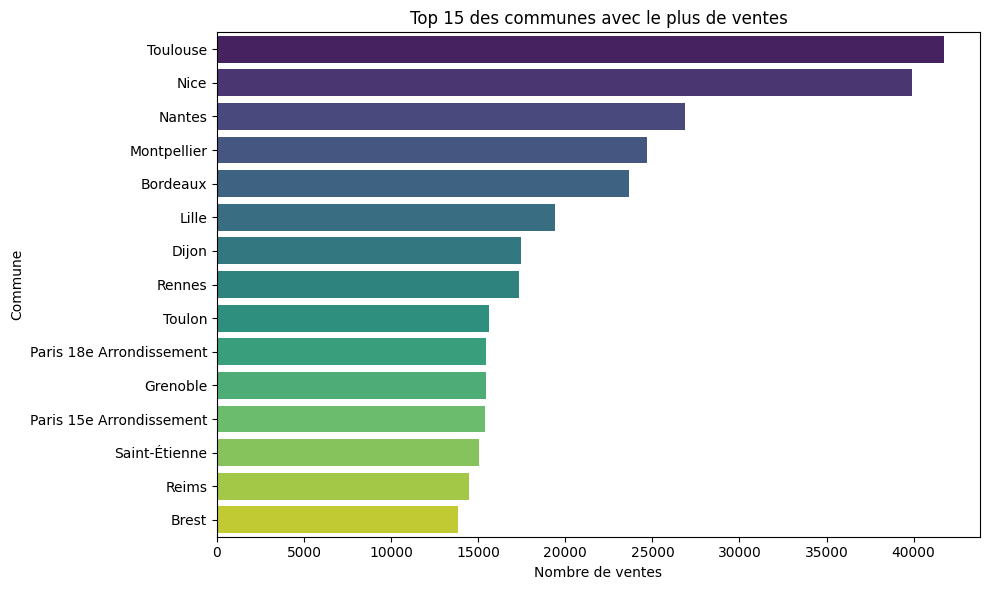

In [23]:
data_analysis.graph_ventes_par_communes(ventes_par_commune)

### 2. Données de population

Afin d'étudier la dynamique autour du secteur immobilier (restreint aux maisons et aux appartements, marché de l'occasion sans lots), il nous est nécessaire d'utiliser les données de population du territoire français. Pour cela, nous utilisons les données de XXX.

In [ ]:
df_pop = get_data.get_pop()

Certaines valeurs ne sont toutefois pas renseignées ; on remarque aussi que certaines communes ont des populations très faibles.
Pour que le ratio des ventes sur la population ait du sens, il nous faut éliminer les communes ayant une population très faible (en particulier, la commune de Bezonvaux ne comptant aucun habitant...).
On imposte donc un nombre minimum d'habitants arbitraire, et on exclut les communes de population trop faible ou non renseignée.

PARTIE INUTILE MAISEFFECTUE PLUS TARD ASKIP

In [ ]:
lignes_na = data_clean.filtre_donnes_pop(df_pop)
print(lignes_na)

       objectid  reg dep    cv code_commune                  libgeo  p13_pop  \
3435     128717   26  21  2115        21507               Premières    140.0   
8276     116240   24  45  4504        45287    Saint-Loup-de-Gonois     97.0   
11971    143352   52  53  5306        53274                 Vimarcé    236.0   
12193    143465   54  16  1607        16351            Saint-Simeux    589.0   
19186    134748   52  53  5306        53239  Saint-Martin-de-Connée    411.0   
26133    122832   23  27  2712        27676                Venables    794.0   
28348    125987   26  21  2107        21213               Crimolois    759.0   

       p14_pop  p15_pop  p16_pop  p17_pop  p18_pop  p19_pop  p20_pop  p21_pop  
3435     140.0    141.0    141.0      141      NaN      NaN      NaN      NaN  
8276      91.0     89.0     86.0       97      NaN      NaN      NaN      NaN  
11971    242.0    241.0    240.0      237    234.0      NaN      NaN      NaN  
12193    598.0    607.0    610.0      5

Nous remarquons que certains codes communes sont à six chiffres. En effet, dans les DOMs, le numéro commence par un code département à trois chiffres plutôt qu'à deux (pour différencier les DOMs).
Cela n'est pas un problème en soit, mais la convention adoptée dans le fichier DVF est différente ; on ne rajoute pas le troisième chiffre.
Par exemple, le code commune est différent dans *df_pop* et *df* pour la commune de Salazie, à la Réunion (974421 dans *df_pop*, 97421 dans *df*) : la Réunion est perçue comme le département 974 dans *df_pop*. On va ainsi supprimer le troisième chiffre de chacun des codes communes à 6 chiffres.


In [ ]:
# Problème des codes communes à 6 chiffres :
print(df_pop[df_pop['code_commune']=='974421'])
lignes_6_chiffres = df_pop[df_pop["code_commune"].str.len() == 6]
print(lignes_6_chiffres)
print(df_pop[df_pop['code_commune']=='974421']['libgeo'])
print(df[df['code_commune']=='97421']['nom_commune'])

      objectid  reg  dep     cv code_commune   libgeo  p13_pop  p14_pop  \
3786    131030    4  974  97406       974421  Salazie   7226.0   7132.0   

      p15_pop  p16_pop  p17_pop  p18_pop  p19_pop  p20_pop  p21_pop  
3786   7384.0   7400.0     7312   7224.0   7136.0   7310.0   7243.0  
       objectid  reg  dep     cv code_commune                  libgeo  \
84       126394    3  973    973       973353             Maripasoula   
192      126587    3  973    973       973313  Montsinéry-Tonnegrande   
206      126601    3  973    973       973358              Saint-Élie   
210      126605    1  971  97114       971102           Anse-Bertrand   
748      130678    1  971  97195       971106              Bouillante   
...         ...  ...  ...    ...          ...                     ...   
33141    115576    2  972    972       972225            Saint-Pierre   
33257    111336    4  974  97401       974404           L' Étang-Salé   
33557    111383    2  972    972       972201      L

In [ ]:
# Harmonisation :
df_pop["code_commune"] = df_pop["code_commune"].apply(data_clean.enleverchiffreDOMs)
print(df_pop)
lignes_6_chiffres = df_pop[df_pop["code_commune"].str.len() == 6]
print(lignes_6_chiffres)
print(df_pop[df_pop['code_commune']=='974421'])

       objectid  reg dep    cv code_commune                 libgeo  p13_pop  \
0        115658   52  85  8502        85062            Châteauneuf    968.0   
1        115659   26  58  5808        58300                   Urzy   1839.0   
2        115660   43  70  7012        70137  Chassey-lès-Montbozon    218.0   
3        115661   21  51  5123        51649      Vitry-le-François  13174.0   
4        115662   11  78  7811        78638         Vaux-sur-Seine   4749.0   
...         ...  ...  ..   ...          ...                    ...      ...   
34990    110251   31  62  6225        62327         Febvin-Palfart    574.0   
34991    110252   73  12  1201        12156            Montpeyroux    550.0   
34992    110253   54  86  8610        86138                Luchapt    275.0   
34993    110254   72  33  3320        33184                Générac    579.0   
34994    110255   72  24  2409        24354       La Roche-Chalais   2932.0   

       p14_pop  p15_pop  p16_pop  p17_pop  p18_pop 

#### Ventes par commune
On joint ensuite les données de population à celles des données foncières.

In [ ]:
ventes_par_commune_par_habitant = pd.merge(ventes_par_commune, df_pop, on='code_commune')
ventes_par_commune_par_habitant = ventes_par_commune_par_habitant[
    (ventes_par_commune_par_habitant['p19_pop'].notna()) &
    (ventes_par_commune_par_habitant['p19_pop'] > 1000)
]
ventes_par_commune_par_habitant['ventes par habitants par commune'] = ventes_par_commune_par_habitant['nombre']/ventes_par_commune_par_habitant['p19_pop']

print(ventes_par_commune_par_habitant['ventes par habitants par commune'])
print(ventes_par_commune_par_habitant['ventes par habitants par commune'].max())
print(ventes_par_commune_par_habitant['ventes par habitants par commune'].idxmax())
print(ventes_par_commune_par_habitant['code_commune'][ventes_par_commune_par_habitant['ventes par habitants par commune'].idxmax()])

0        0.102710
1        0.136274
2        0.095139
3        0.115256
4        0.097878
           ...   
22363    0.014115
26593    0.015238
30690    0.005638
31746    0.000683
32063    0.000527
Name: ventes par habitants par commune, Length: 9422, dtype: float64
1.172281776416539
611
38191


#### Tentative de récupération des prix au mètre carré

Remarque : on ne considère que le ratio *valeur foncière/surface batîe* de la maison ou de l'appartement, puisqu'on ignore les dépendances ou autres terrains additionnels.
On sur-estime donc la valeur au m2. On ignore les lots (on utilise *df_sans_lots* qui ne contient pas les observations dont l'id_mutation apparaît plusieurs fois).


In [ ]:
df_sans_lots = df_sans_lots.copy()
print(df_sans_lots.shape)

df_sans_lots = df_sans_lots[
    (df_sans_lots['surface_reelle_bati'].notna()) &
    (df_sans_lots['valeur_fonciere'].notna()) &
    (df_sans_lots['surface_reelle_bati'] > 10)
]

# Définition du rapport de la valeur foncière sur la surface :
df_sans_lots['rapport valeur foncière et surface bâtie']=df_sans_lots['valeur_fonciere']/df_sans_lots['surface_reelle_bati']

print(df_sans_lots['rapport valeur foncière et surface bâtie'])
print(df_sans_lots['rapport valeur foncière et surface bâtie'].max())
print(df_sans_lots['rapport valeur foncière et surface bâtie'].idxmax())
print(df_sans_lots.loc[df_sans_lots['rapport valeur foncière et surface bâtie'].idxmax()])

(4133749, 41)
0            669.565217
1           2286.885246
2           2220.625000
3           1966.406977
4           1666.666667
               ...     
6247210    11928.571429
6247211    11363.636364
6247212    14891.304348
6247213     9016.393443
6247214    11710.342553
Name: rapport valeur foncière et surface bâtie, Length: 4125604, dtype: float64
15937500.0
5816283
index                                                      18656556
id_mutation                                            2024-1198671
date_mutation                                            2024-06-27
numero_disposition                                                1
nature_mutation                                               Vente
valeur_fonciere                                         255000000.0
adresse_numero                                                 42.0
adresse_suffixe                                                 NaN
adresse_nom_voie                                       AV MONTAIGNE
adresse_cod

Problème : on trouve des valeurs anormalement élevées pour certains logements, correspondant probablement à des immeubles entiers plutôt qu'à des logements (ci-dessus, immeuble en construction de presque 1 milliard d'euros...).

In [ ]:
# Moyenne par commune :
moyenne_par_commune=df_sans_lots.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()
print(moyenne_par_commune['rapport valeur foncière et surface bâtie'].max())
print(moyenne_par_commune['code_commune'].loc[moyenne_par_commune['rapport valeur foncière et surface bâtie'].idxmax()])


# Médiane par commune
mediane_par_commune = df_sans_lots.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()
# Valeur maximale de la médiane
print(mediane_par_commune['rapport valeur foncière et surface bâtie'].max())
# Code de la commune avec la médiane maximale
print(mediane_par_commune['code_commune'][mediane_par_commune['rapport valeur foncière et surface bâtie'].idxmax()])

39178.54209868362
25448
14752.04918032787
75106


On retire dns ce contexte les 5% de valeurs les plus extrêmes. Il est cependant important de réaliser cette troncature par commune plutôt qu'au niveau national ; on effet on introduirait autrement un biais, les prix dans des communes chères comme le sixième arrondissement parisien pouvant sembler extrêmes au niveau national sans l'être au niveau local. 

On trouve alors des médianes et des moyennes très proches, maximales pour le sixième arrondissement de Paris, ce qui est cohérent !


In [ ]:
df_sans_lots_tronqué = data_clean.troncature_lots(df_sans_lots)


# Calcul de la moyenne par commune (tronqué)
moyenne_par_commune_tronqué = df_sans_lots_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].mean().reset_index()

# Affichage de la moyenne maximale et de la commune associée
print(moyenne_par_commune_tronqué['rapport valeur foncière et surface bâtie'].max())
print(moyenne_par_commune_tronqué['code_commune'].loc[moyenne_par_commune_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

# Calcul de la médiane par commune (tronqué)
mediane_par_commune_tronqué = df_sans_lots_tronqué.groupby('code_commune')['rapport valeur foncière et surface bâtie'].median().reset_index()

# Affichage de la médiane maximale et de la commune associée
print(mediane_par_commune_tronqué['rapport valeur foncière et surface bâtie'].max())
print(mediane_par_commune_tronqué['code_commune'][mediane_par_commune_tronqué['rapport valeur foncière et surface bâtie'].idxmax()])

14889.448668014387
75106
14752.04918032787
75106


Cependant, les résultats précédents ne tiennent pas compte des variations de prix d'une année à l'autre, qui peuvent devenir un problème puisque les données s'étalent sur 5 ans. Il semble alors nécessaire de calculer les moyennes et médianes annuelles. Il faut dans ce cas également tronquer au niveau annuel sans quoi on risque d'introduire un biais (les ventes les plus récentes sont plus chères et donc perçues comme plus extrêmes)

In [ ]:
df_2020=df_sans_lots[int(df_sans_lots['date_mutation'][:4])==2020]
df_2021=df_sans_lots[int(df_sans_lots['date_mutation'][:4])==2021]
df_2022=df_sans_lots[int(df_sans_lots['date_mutation'][:4])==2022]
df_2023=df_sans_lots[int(df_sans_lots['date_mutation'][:4])==2023]
df_2024=df_sans_lots[int(df_sans_lots['date_mutation'][:4])==2024]
df_2025=df_sans_lots[int(df_sans_lots['date_mutation'][:4])==2025]


On crée, enfin, un dataframe complet contenant toutes les données pertinentes par commune.
Attention : les données sur les ventes par habitant ont été crées plus tôt en se restreignant aux communes avec au moins un certain nombre d'ventes_par_commune_par_habitant_simple.
#Remonter et changer de seuil si on veut élargir au restreindre le champ des données
#!!!Dans tous les cas il y aura pas mal de valeurs manquantes pour les données en question, bien faire gaffe à ce qu'on étudie!!!


In [ ]:
pop_par_commune=df_pop[["code_commune", "p19_pop","libgeo"]]
ventes_par_commune_par_habitant_simple = ventes_par_commune_par_habitant[["code_commune", "ventes par habitants par commune"]]


df_final=pd.merge(pop_par_commune, ventes_par_commune, how='outer', on="code_commune")
df_final.rename(columns={'nombre': 'nombre de ventes dans la commune'}, inplace=True)
df_final.rename(columns={'libgeo': 'nom de la commune'}, inplace=True)
df_final.rename(columns={'p19_pop': 'population en 2019'}, inplace=True)
df_final=pd.merge(df_final, ventes_par_commune_par_habitant_simple, how='outer', on="code_commune")
df_final.rename(columns={'ventes par habitants par commune': 'nombre de ventes par habitant en 2019 dans la commune'}, inplace=True)
df_final=pd.merge(df_final, mediane_par_commune_tronqué , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'médiane tronquée du prix au m2'}, inplace=True)
df_final=pd.merge(df_final, moyenne_par_commune_tronqué , how='outer', on="code_commune")
df_final.rename(columns={'rapport valeur foncière et surface bâtie': 'moyenne tronquée du prix au m2'}, inplace=True)
print(df_final)

print(df_final['moyenne tronquée du prix au m2'].max())
print(df_final['code_commune'][df_final['moyenne tronquée du prix au m2'].idxmax()])

      code_commune  population en 2019         nom de la commune  \
0            01001               779.0  L' Abergement-Clémenciat   
1            01002               256.0    L' Abergement-de-Varey   
2            01004             14134.0         Ambérieu-en-Bugey   
3            01005              1751.0       Ambérieux-en-Dombes   
4            01006               112.0                   Ambléon   
...            ...                 ...                       ...   
34995        97420             24065.0            Sainte-Suzanne   
34996        97421              7136.0                   Salazie   
34997        97422             79824.0                 Le Tampon   
34998        97423              7015.0         Les Trois-Bassins   
34999        97424              5538.0                    Cilaos   

       nombre de ventes dans la commune  \
0                                  59.0   
1                                  21.0   
2                                1280.0   
3          

Il reste des NaN dans le df_final... ????????????

In [ ]:
df_final

code_commune  population en 2019         nom de la commune  \
0            01001               779.0  L' Abergement-Clémenciat   
1            01002               256.0    L' Abergement-de-Varey   
2            01004             14134.0         Ambérieu-en-Bugey   
3            01005              1751.0       Ambérieux-en-Dombes   
4            01006               112.0                   Ambléon   
...            ...                 ...                       ...   
34995        97420             24065.0            Sainte-Suzanne   
34996        97421              7136.0                   Salazie   
34997        97422             79824.0                 Le Tampon   
34998        97423              7015.0         Les Trois-Bassins   
34999        97424              5538.0                    Cilaos   

       nombre de ventes dans la commune  \
0                                  59.0   
1                                  21.0   
2                                1280.0   
3                                 235.0   
4                                  16.0   
...                                 ...   
34995                            1042.0   
34996                             228.0   
34997                            4277.0   
34998                             258.0   
34999                             178.0   

       nombre de ventes par habitant en 2019 dans la commune  \
0                                                    NaN       
1                                                    NaN       
2                                               0.090562       
3                                               0.134209       
4                                                    NaN       
...                                                  ...       
34995                                           0.043299       
34996                                           0.031951       
34997                                           0.053580       
34998                                           0.036778       
34999                                           0.032142       

       médiane tronquée du prix au m2  moyenne tronquée du prix au m2  
0                         2431.034483                     2483.602665  
1                         1769.026549                     1719.646511  
2                         2284.701114                     2354.881148  
3                         2812.820513                     2803.968537  
4                         1688.688525                     1626.384067  
...                               ...                             ...  
34995                     2169.996032                     2198.182140  
34996                     1458.185684                     1396.345521  
34997                     2228.571429                     2393.514030  
34998                     2500.000000                     3017.406091  
34999                     1578.947368                     1768.829934  

[35000 rows x 7 columns]

## Visualisation (à intégrer)

In [ ]:
data_visualization.carte_repartition_ventes(df)

Données créées : 33197 communes


Statistiques des surfaces par type de bien :
                 count       mean        std   min   25%   50%    75%    max
type_local                                                                  
Appartement  1989773.0  57.866097  27.077960  11.0  39.0  56.0   72.0  299.0
Maison       2128863.0  97.228418  37.672456  11.0  73.0  91.0  115.0  299.0


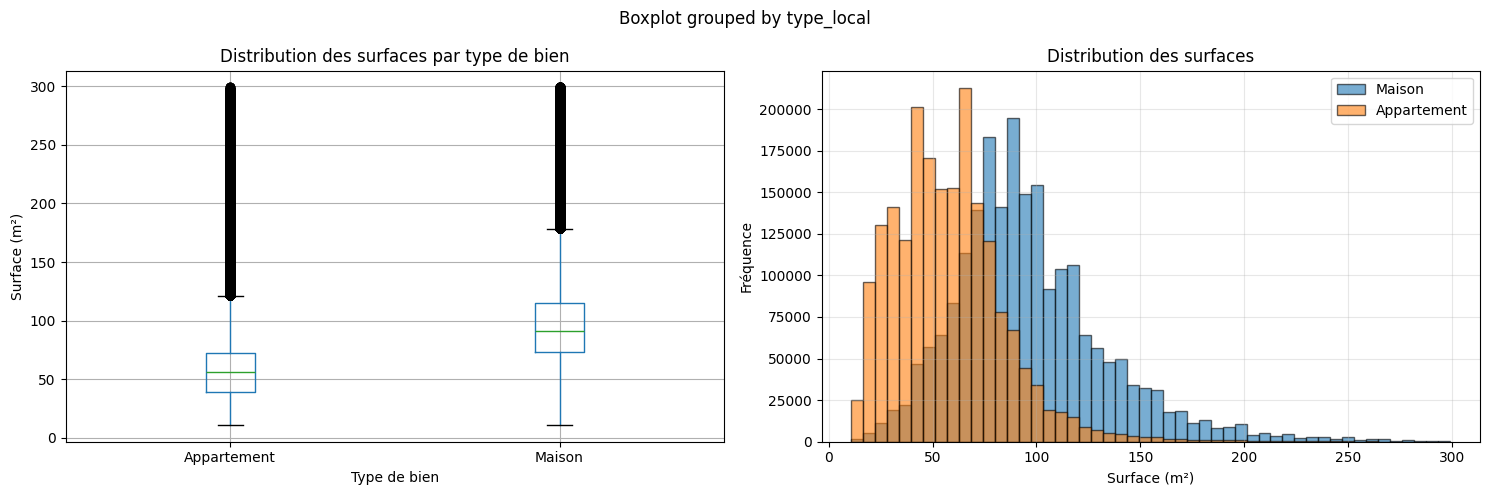

In [ ]:
data_visualization.surfaces(df_sans_lots)

Statistiques du prix au m² par type de bien :
                 count         mean          std       min          25%  \
type_local                                                                
Appartement  1909821.0  4027.951695  2757.148995  0.014085  2200.000000   
Maison       1972896.0  2413.135913  1574.333603  0.005747  1364.347826   

                     50%          75%           max  
type_local                                           
Appartement  3325.581395  4886.206349  39428.571429  
Maison       2089.552239  3075.000000  53083.333333  


/home/onyxia/work/Python_2A/scripts/data_analysis.py:40: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



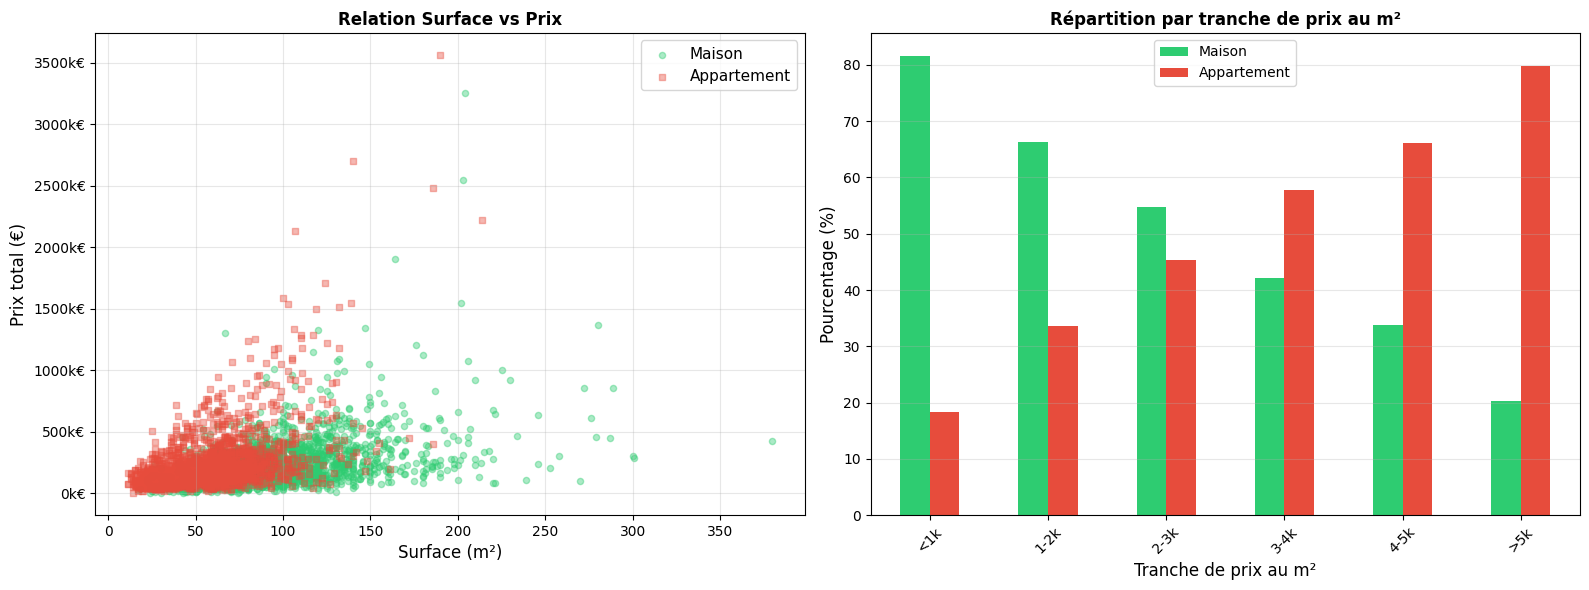

In [ ]:
data_analysis.relation_surface_prix(df_sans_lots_tronqué)


In [ ]:
# Extraire le département du code commune (2 premiers caractères)
df['departement'] = df['code_commune'].str[:2]

data_analysis.top_departements(df)

Statistiques calculées pour 6247215 départements

Top 10 départements par nombre de ventes :
   index id_mutation date_mutation  numero_disposition  \
0     17      2020-6    2020-07-02                   1   
1     31      2020-8    2020-07-01                   1   
2     32      2020-9    2020-07-02                   1   
3     36     2020-11    2020-07-03                   1   
4     37     2020-12    2020-07-02                   1   
5     41     2020-13    2020-07-03                   1   
6     43     2020-14    2020-07-02                   1   
7     45     2020-15    2020-07-02                   1   
8     51     2020-18    2020-07-07                   1   
9     53     2020-19    2020-07-09                   1   

                      nature_mutation  valeur_fonciere  adresse_numero  \
0                               Vente          77000.0           347.0   
1                               Vente         279000.0          1084.0   
2                               Vente         

In [ ]:
# Données de densité de population par département (France métropolitaine)
dept_data = {
    '01': {'nom': 'Ain', 'population': 652000, 'superficie': 5762},
    '02': {'nom': 'Aisne', 'population': 531000, 'superficie': 7369},
    '03': {'nom': 'Allier', 'population': 335000, 'superficie': 7340},
    '04': {'nom': 'Alpes-de-Haute-Provence', 'population': 164000, 'superficie': 6925},
    '05': {'nom': 'Hautes-Alpes', 'population': 141000, 'superficie': 5549},
    '06': {'nom': 'Alpes-Maritimes', 'population': 1083000, 'superficie': 4299},
    '07': {'nom': 'Ardèche', 'population': 328000, 'superficie': 5529},
    '08': {'nom': 'Ardennes', 'population': 270000, 'superficie': 5229},
    '09': {'nom': 'Ariège', 'population': 153000, 'superficie': 4890},
    '10': {'nom': 'Aube', 'population': 310000, 'superficie': 6004},
    '11': {'nom': 'Aude', 'population': 374000, 'superficie': 6139},
    '12': {'nom': 'Aveyron', 'population': 279000, 'superficie': 8735},
    '13': {'nom': 'Bouches-du-Rhône', 'population': 2043000, 'superficie': 5087},
    '14': {'nom': 'Calvados', 'population': 694000, 'superficie': 5548},
    '15': {'nom': 'Cantal', 'population': 144000, 'superficie': 5726},
    '16': {'nom': 'Charente', 'population': 352000, 'superficie': 5956},
    '17': {'nom': 'Charente-Maritime', 'population': 651000, 'superficie': 6864},
    '18': {'nom': 'Cher', 'population': 302000, 'superficie': 7235},
    '19': {'nom': 'Corrèze', 'population': 240000, 'superficie': 5857},
    '21': {'nom': "Côte-d'Or", 'population': 534000, 'superficie': 8763},
    '22': {'nom': "Côtes-d'Armor", 'population': 600000, 'superficie': 6878},
    '23': {'nom': 'Creuse', 'population': 116000, 'superficie': 5565},
    '24': {'nom': 'Dordogne', 'population': 413000, 'superficie': 9060},
    '25': {'nom': 'Doubs', 'population': 543000, 'superficie': 5234},
    '26': {'nom': 'Drôme', 'population': 516000, 'superficie': 6530},
    '27': {'nom': 'Eure', 'population': 599000, 'superficie': 6040},
    '28': {'nom': 'Eure-et-Loir', 'population': 431000, 'superficie': 5880},
    '29': {'nom': 'Finistère', 'population': 915000, 'superficie': 6733},
    '30': {'nom': 'Gard', 'population': 748000, 'superficie': 5853},
    '31': {'nom': 'Haute-Garonne', 'population': 1415000, 'superficie': 6309},
    '32': {'nom': 'Gers', 'population': 191000, 'superficie': 6257},
    '33': {'nom': 'Gironde', 'population': 1623000, 'superficie': 9976},
    '34': {'nom': 'Hérault', 'population': 1175000, 'superficie': 6101},
    '35': {'nom': 'Ille-et-Vilaine', 'population': 1079000, 'superficie': 6775},
    '36': {'nom': 'Indre', 'population': 219000, 'superficie': 6791},
    '37': {'nom': 'Indre-et-Loire', 'population': 610000, 'superficie': 6127},
    '38': {'nom': 'Isère', 'population': 1271000, 'superficie': 7431},
    '39': {'nom': 'Jura', 'population': 259000, 'superficie': 4999},
    '40': {'nom': 'Landes', 'population': 413000, 'superficie': 9243},
    '41': {'nom': 'Loir-et-Cher', 'population': 329000, 'superficie': 6343},
    '42': {'nom': 'Loire', 'population': 765000, 'superficie': 4781},
    '43': {'nom': 'Haute-Loire', 'population': 227000, 'superficie': 4977},
    '44': {'nom': 'Loire-Atlantique', 'population': 1429000, 'superficie': 6815},
    '45': {'nom': 'Loiret', 'population': 680000, 'superficie': 6775},
    '46': {'nom': 'Lot', 'population': 174000, 'superficie': 5217},
    '47': {'nom': 'Lot-et-Garonne', 'population': 333000, 'superficie': 5361},
    '48': {'nom': 'Lozère', 'population': 76000, 'superficie': 5167},
    '49': {'nom': 'Maine-et-Loire', 'population': 818000, 'superficie': 7166},
    '50': {'nom': 'Manche', 'population': 496000, 'superficie': 5938},
    '51': {'nom': 'Marne', 'population': 566000, 'superficie': 8162},
    '52': {'nom': 'Haute-Marne', 'population': 172000, 'superficie': 6211},
    '53': {'nom': 'Mayenne', 'population': 307000, 'superficie': 5175},
    '54': {'nom': 'Meurthe-et-Moselle', 'population': 733000, 'superficie': 5246},
    '55': {'nom': 'Meuse', 'population': 184000, 'superficie': 6211},
    '56': {'nom': 'Morbihan', 'population': 750000, 'superficie': 6823},
    '57': {'nom': 'Moselle', 'population': 1043000, 'superficie': 6216},
    '58': {'nom': 'Nièvre', 'population': 204000, 'superficie': 6817},
    '59': {'nom': 'Nord', 'population': 2604000, 'superficie': 5743},
    '60': {'nom': 'Oise', 'population': 829000, 'superficie': 5860},
    '61': {'nom': 'Orne', 'population': 279000, 'superficie': 6103},
    '62': {'nom': 'Pas-de-Calais', 'population': 1465000, 'superficie': 6671},
    '63': {'nom': 'Puy-de-Dôme', 'population': 662000, 'superficie': 7970},
    '64': {'nom': 'Pyrénées-Atlantiques', 'population': 682000, 'superficie': 7645},
    '65': {'nom': 'Hautes-Pyrénées', 'population': 229000, 'superficie': 4464},
    '66': {'nom': 'Pyrénées-Orientales', 'population': 479000, 'superficie': 4116},
    '67': {'nom': 'Bas-Rhin', 'population': 1140000, 'superficie': 4755},
    '68': {'nom': 'Haut-Rhin', 'population': 767000, 'superficie': 3525},
    '69': {'nom': 'Rhône', 'population': 1873000, 'superficie': 3249},
    '70': {'nom': 'Haute-Saône', 'population': 235000, 'superficie': 5360},
    '71': {'nom': 'Saône-et-Loire', 'population': 551000, 'superficie': 8575},
    '72': {'nom': 'Sarthe', 'population': 566000, 'superficie': 6206},
    '73': {'nom': 'Savoie', 'population': 436000, 'superficie': 6028},
    '74': {'nom': 'Haute-Savoie', 'population': 825000, 'superficie': 4388},
    '75': {'nom': 'Paris', 'population': 2161000, 'superficie': 105},
    '76': {'nom': 'Seine-Maritime', 'population': 1255000, 'superficie': 6278},
    '77': {'nom': 'Seine-et-Marne', 'population': 1421000, 'superficie': 5915},
    '78': {'nom': 'Yvelines', 'population': 1431000, 'superficie': 2284},
    '79': {'nom': 'Deux-Sèvres', 'population': 374000, 'superficie': 5999},
    '80': {'nom': 'Somme', 'population': 570000, 'superficie': 6170},
    '81': {'nom': 'Tarn', 'population': 387000, 'superficie': 5758},
    '82': {'nom': 'Tarn-et-Garonne', 'population': 260000, 'superficie': 3718},
    '83': {'nom': 'Var', 'population': 1076000, 'superficie': 5973},
    '84': {'nom': 'Vaucluse', 'population': 559000, 'superficie': 3567},
    '85': {'nom': 'Vendée', 'population': 685000, 'superficie': 6720},
    '86': {'nom': 'Vienne', 'population': 438000, 'superficie': 6990},
    '87': {'nom': 'Haute-Vienne', 'population': 374000, 'superficie': 5520},
    '88': {'nom': 'Vosges', 'population': 364000, 'superficie': 5874},
    '89': {'nom': 'Yonne', 'population': 338000, 'superficie': 7427},
    '90': {'nom': 'Territoire de Belfort', 'population': 141000, 'superficie': 609},
    '91': {'nom': 'Essonne', 'population': 1301000, 'superficie': 1804},
    '92': {'nom': 'Hauts-de-Seine', 'population': 1609000, 'superficie': 176},
    '93': {'nom': 'Seine-Saint-Denis', 'population': 1632000, 'superficie': 236},
    '94': {'nom': "Val-de-Marne", 'population': 1398000, 'superficie': 245},
    '95': {'nom': "Val-d'Oise", 'population': 1249000, 'superficie': 1246},
}

# Créer un DataFrame avec ces données
df_dept_info = pd.DataFrame.from_dict(dept_data, orient='index')
df_dept_info.index.name = 'departement'
df_dept_info.reset_index(inplace=True)

# Calculer la densité (habitants/km²)
df_dept_info['densite'] = df_dept_info['population'] / df_dept_info['superficie']

print(f"✓ Données chargées pour {len(df_dept_info)} départements")
print("\n5 départements les plus denses :")
print(df_dept_info.nlargest(5, 'densite')[['departement', 'nom', 'densite']])

# Calculer les statistiques par département
geo_stats = df.groupby(['departement', 'type_local']).size().unstack(fill_value=0)
geo_stats['total'] = geo_stats.sum(axis=1)
geo_stats['pct_maison'] = (geo_stats['Maison'] / geo_stats['total']) * 100
geo_stats['pct_appartement'] = (geo_stats['Appartement'] / geo_stats['total']) * 100

# Trier par nombre total de ventes
geo_stats_sorted = geo_stats.sort_values('total', ascending=False)

# Fusionner avec les données de densité
geo_stats_with_info = geo_stats_sorted.reset_index().merge(df_dept_info, on='departement', how='left')

# Créer une colonne pour l'affichage avec nom du département
geo_stats_with_info['dept_nom'] = geo_stats_with_info['departement'] + ' - ' + geo_stats_with_info['nom'].fillna('Inconnu')


✓ Données chargées pour 94 départements

5 départements les plus denses :
   departement                nom       densite
73          75              Paris  20580.952381
90          92     Hauts-de-Seine   9142.045455
91          93  Seine-Saint-Denis   6915.254237
92          94       Val-de-Marne   5706.122449
93          95         Val-d'Oise   1002.407705


In [ ]:

data_analysis.pourcentage_maisons_appartements(geo_stats_with_info)

In [ ]:
data_visualization.correlation_densite_appartements(geo_stats_with_info)

/home/onyxia/work/Python_2A/scripts/data_analysis.py:92: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



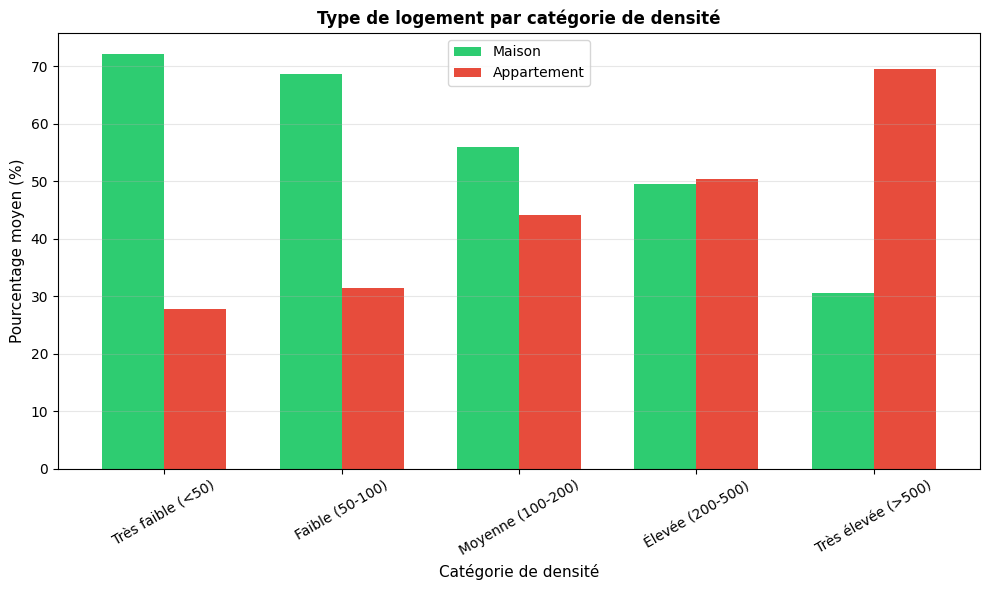

In [ ]:
data_analysis.histogramme_densite(geo_stats_with_info)

In [ ]:
# m = data_visualization.carte_a_densite(df)
# m.save("/home/onyxia/work/Python_2A/carte_heatmap.html")
# On se contente ici de n'afficher qu'une capture d'écran de la carte interractive, car elle n'est pas supportée ici :

![Carte de densité](carte_heatmap.png)

## III. Analyse

### 1. Données de régression

Nous allons tenter d'effectuer une régression du nombre de ventes par communes sur différents paramètres. Nous choisissons en premier lieu trois paramètres variés : l'IDH (Indice de Développement Humain), la criminalité et la population de pharmacie.

In [ ]:
pharmacies = get_data.get_local_csv('pharmacies_point')
idh = get_data.get_local_csv('indice-de-developpement-humain-idh2-des-communes-dile-de-france', sep=';')
crime = get_data.get_local_csv('donnee-dep-data.gouv-2024-geographie2025-produit-le2025-06-04', sep=';')

/home/onyxia/work/Python_2A/scripts/get_data.py:54: DtypeWarning:

Columns (4,11,16,32,34) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
idh

﻿objectid  insee  annee  sante_plaf  educ_plaf  revenu_plaf      idh2  \
0           238  77227   2013    0.720523   0.345290     0.484803  0.516872   
1           345  77336   2013    0.683653   0.516738     0.595381  0.598591   
2           354  77345   2013    0.480528   0.427034     0.540652  0.482738   
3           359  77352   2013    0.648913   0.495740     0.604881  0.583178   
4           447  77443   2013    0.414469   0.465897     0.557855  0.479407   
...         ...    ...    ...         ...        ...          ...       ...   
3892       3393  78688   1999    0.682321   0.757054     0.702444  0.713940   
3893       3529  91495   1999    0.533446   0.229520     0.489062  0.417343   
3894       3572  91645   1999    0.560198   0.642285     0.749182  0.650555   
3895       3655  93063   1999    0.376183   0.110453     0.292421  0.259686   
3896       3754  95144   1999         NaN   0.781418          NaN       NaN   

                     nomcom    pop  
0                     Hermé    646  
1      Neufmoutiers-en-Brie    921  
2            Orly-sur-Morin    676  
3         Ozouer-le-Voulgis   1837  
4                     Sancy    379  
...                     ...    ...  
3892  Voisins-le-Bretonneux  12150  
3893  Plessis-Saint-Benoist    273  
3894   Verrières-le-Buisson  15929  
3895            Romainville  23774  
3896     Châtenay-en-France     61  

[3897 rows x 9 columns]

In [ ]:
test = get_data.get_local_csv('dossier_complet',sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '/home/onyxia/work/Python_2A/scripts/../Données/dossier_complet.csv'

In [ ]:
test['CODGEO'] = test['CODGEO'].astype(str)
test['CODGEO'] = test['CODGEO'].str.zfill(5)

In [ ]:
test = test.set_index('CODGEO')

In [ ]:
test

In [ ]:
test2 = get_local_csv('meta_dossier_complet',sep=';')

In [ ]:
test2

In [ ]:
for i in test.columns:
    lib = test2.loc[test2['COD_VAR'] == i, 'LIB_VAR_LONG'].values
    if lib.size > 0:
        print(f"{i} {lib[0]}")
    else:
        print(f"{i} errror")

In [ ]:
lista = ['P']
for col in test.columns:
    n_nan = test[col].isna().sum()  
    print(f"{col} - {n_nan}")

In [ ]:
X_appartment = prepare_regression_dataset(test,var_explicative_appartment)

In [ ]:
X_appartment

In [ ]:
prix_m2_appartment  = df_final['moyenne tronquée du prix au m2'].dropna()

In [ ]:
prix_m2_appartment

In [ ]:
import importlib
import scripts.getvis
importlib.reload(scripts.getvis)

In [ ]:
from scripts.do_ols import run_log_ols_regression

In [ ]:
model = run_log_ols_regression(prix_m2_appartment, X_appartment)
print(model.summary())

In [ ]:
from scripts.getvis import plot_log_ols_regression

In [ ]:
plot_log_ols_regression(model,prix_m2_appartment,X_appartment,title='Régression log-OLS Appartment')

In [ ]:
plot_log_ols_regression(model,prix_m2_appartment,X_appartment,title='Régression log-OLS Appartment')

## Conclusion et perspectives

En conclusion, 